## Monte Carlo simulation of stable membrane curvatures

##### Using functions from mem_curve.py

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import pandas as pd
import os
# For reading csv
import csv
import re
# For power spectrum
from scipy.signal import periodogram

# Custom imports
from mem_curve import *

### Running simulation, replica exchange, annealing

#### Simulation:
Initialise model membrane --  parametrised by Fourier series coefficients and over descrete grid -- run Monte Carlo for <$n$> steps using Helfrich bending energy


#### Fourier Surface:
$
h(x, y) =
\sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \alpha_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \beta_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \gamma_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \zeta_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
$

In [19]:
# Choose number of Monte Carlo steps
nsteps = 60000

# Choose directory to save/ load
save_dir = 'trial'
os.makedirs(f'./{save_dir}/', exist_ok=True)

In [3]:
# Initialise membrane ensemble

# Custom initial membrane
membrane_start = {'alpha' : np.zeros((params.exp_order, params.exp_order)),
                  'beta'  : np.zeros((params.exp_order, params.exp_order)),
                  'gamma' : np.zeros((params.exp_order, params.exp_order)),
                  'zeta'  : np.zeros((params.exp_order, params.exp_order))}

#membrane_start['gamma'][2,0] = 1 #  sine wave in x-direction
membrane_start['zeta'][2,2] = 1  #  wave in both x,y-directions

membrane_lst = [ init_model_membrane( membrane_start ) ]

Initial membrane bending energy: 99.13521750996922 kbT , excess area: 39.09592906052694


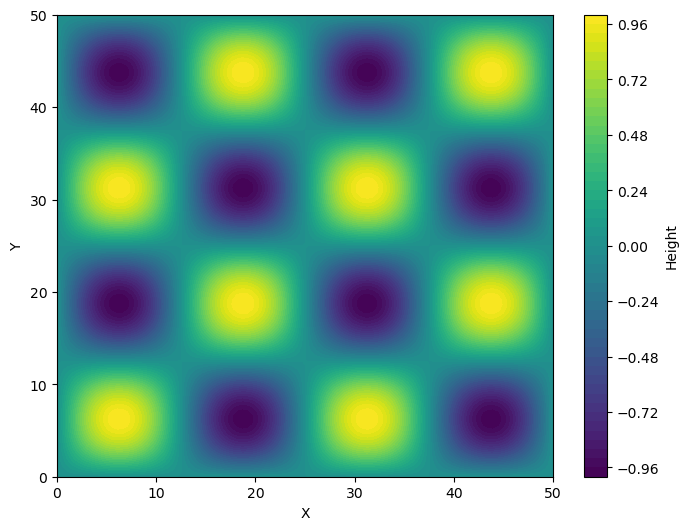

In [4]:
# Visualise starting surface
contour_surface_plot(start_membrane, filename=f'./{save_dir}/start_surface')

In [ ]:
# Track acceptance probability
naccepts       = 0
naccepts_track = []

# Header for prints
print(f"{'Step':<9} {'Accepted Moves':<18} {'Bending Energy (kbT)':<15}\n{'-'*50}")

# Run simulation
for step in range(1,nsteps+1):
    
    membrane_lst, accept_move = montecarlostep(membrane_lst)

    naccepts += 1 if accept_move else 0
    naccepts_track += [naccepts]
    
    if step%100==0 and step!=0:
        print(f"{step:<9} {naccepts:<18} {membrane_lst[-1]['energy']:<15.2f}")

print('Acceptance ratio:', naccepts/nsteps)

In [8]:
# Save data to a csv
df = pd.DataFrame(membrane_lst)

df.to_csv(f'./{save_dir}/model_membranes.csv', index=False)

### Load data from saved csv

In [20]:
def string_to_array(s):
    s_clean = re.sub(r'[\[\]]', '', s)
    if ' ' not in s_clean:
        return float(s_clean)
    return np.array([[float(x) for x in line.split() if x]
                     for line in s_clean.strip().split('\n')])

with open(f'./{save_dir}/model_membranes.csv', mode='r', newline='') as file:
    reader = csv.DictReader(file)
    membrane_lst = []
    for row in reader:
        parsed_row = {}
        for key, val in row.items():
            parsed_row[key] = string_to_array(val)
        membrane_lst.append(parsed_row)

### Data Analysis

#### Equilibration

How does ratio of accepted moves evolve?

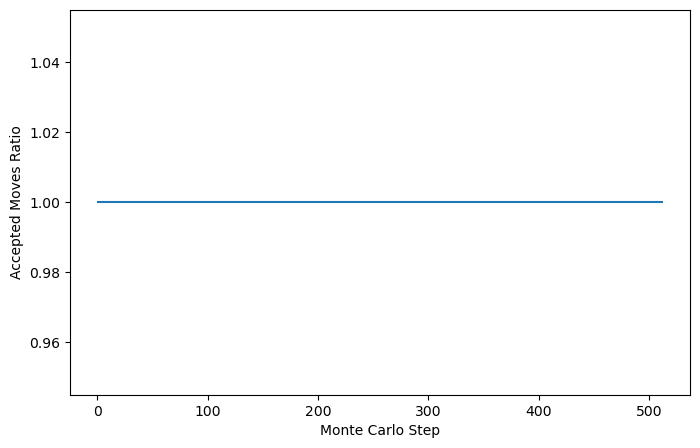

In [9]:
# note: won't work if data has been loaded
mcsteps_arr = np.linspace(1,len(naccepts_track),len(naccepts_track))
ratio_arr = np.array(naccepts_track)/mcsteps_arr

plt.figure(figsize=[8,5])
plt.ylabel('Accepted Moves Ratio')
plt.xlabel('Monte Carlo Step')
plt.plot(mcsteps_arr, ratio_arr)
plt.savefig(f'./{save_dir}/naccepts.pdf')
plt.show()

#### Plot bending energy vs Monte Carlo step

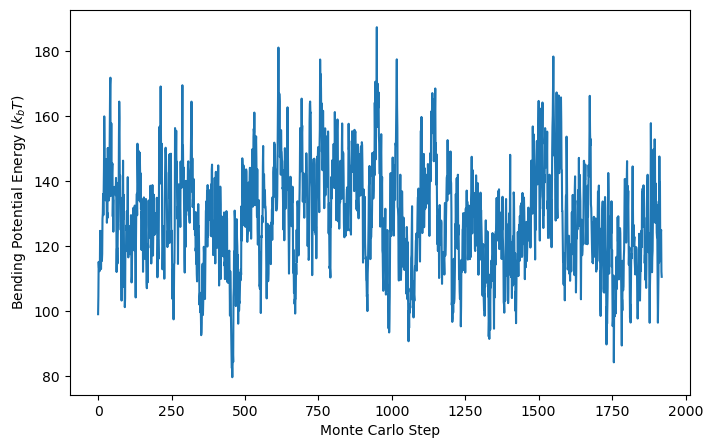

In [10]:
# Extract bending energy from membrane_lst of dictionaries
energy_lst = [ membrane['energy'] for membrane in membrane_lst ]

# Plot energy
plt.figure(figsize=[8,5])
plt.ylabel('Bending Potential Energy ($k_bT$)')
plt.xlabel('Monte Carlo Step')
plt.plot(range(len(energy_lst)), energy_lst)
plt.savefig(f'./{save_dir}/bending_energy.pdf')
plt.show()

#### Plot mean & Gaussian curvature vs Monte Carlo step

In [11]:
# Calculate values every <nframes>
nframes = 10

H_lst  = []
K_lst  = []
dA_lst = []

for membrane in membrane_lst[::nframes]:

    # Calculate local height derivatives from Fourier surface
    h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(membrane, params.X, params.Y)
    # Calculate shape operator
    S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)
    
    # Calculate mean and Gaussian curvatures
    H_lst += [np.sum(calc_H(S))]
    K_lst += [np.sum(calc_K_G(S))] 

    # Calculate change in area from membrane bending
    dA_lst += [np.sum(calc_area_element(h_x, h_y))/params.npts**2]

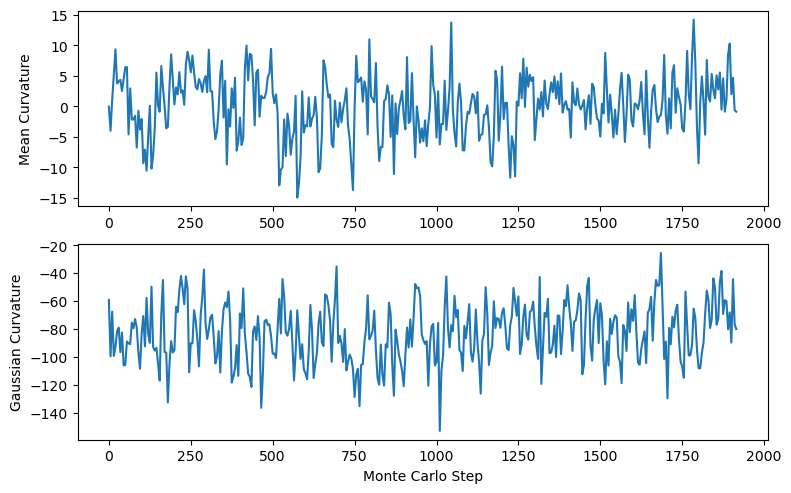

In [12]:
plt.figure(figsize=[8,5])

# Plot mean curvature
plt.subplot(2, 1, 1)
plt.ylabel('Mean Curvature')
plt.plot(range(0,len(membrane_lst),nframes), H_lst)

# Plot Gaussian curvature
plt.subplot(2, 1, 2)
plt.ylabel('Gaussian Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,len(membrane_lst),nframes), K_lst)

plt.tight_layout(pad=1)
plt.savefig(f'./{save_dir}/curvatures.pdf')
plt.show()

#### Box Size

Not change explicitly - derivatives using Fourier coefficients still using raw length - but for in energy calculation

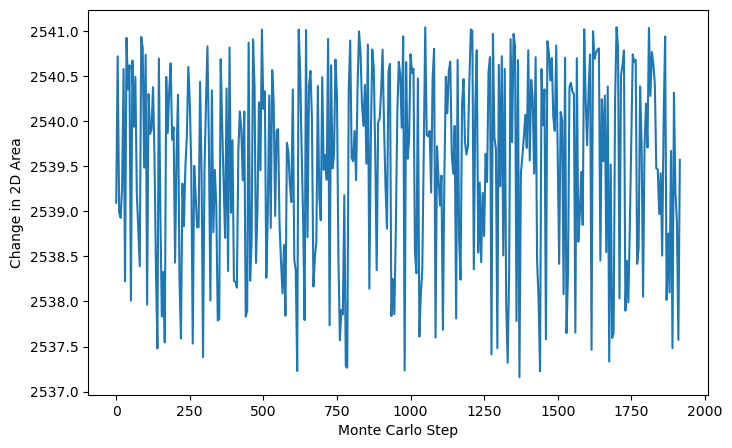

In [13]:
# Starting surface area
sa_start = params.original_excess_area + params.l_x*params.l_y

print(f'''Starting surface area: {sa_start:.0f}
Excess area:           {params.original_excess_area:.0f} +- {params.original_excess_area*params.dA_threshold:.0f}''')

# Plot dA from curvature
plt.figure(figsize=[8,5])
plt.ylabel('Surface Area')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,len(membrane_lst),nframes), dA_lst)
plt.hlines(sa_start, 0, len(membrane_lst), linestyle='--', color='k', label='Starting Surface Area')
plt.legend(loc='best')
plt.savefig(f'./{save_dir}/surfacearea.pdf')
plt.show()

#### Mean Fourier Coefficients

$
h(x, y) =
\sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \alpha_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \beta_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \gamma_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \zeta_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
$


In [14]:
nskip = 0

# Calculate mean Fourier coefficients
alpha_lst, beta_lst, gamma_lst, zeta_lst = [], [], [], []

for membrane in membrane_lst[nskip:]:
    alpha_lst += [membrane['alpha']]
    beta_lst  += [membrane['beta']]
    gamma_lst += [membrane['gamma']]
    zeta_lst  += [membrane['zeta']]

alpha_mean = np.mean(alpha_lst, axis=0)
beta_mean  = np.mean(beta_lst,  axis=0)
gamma_mean = np.mean(gamma_lst, axis=0)
zeta_mean  = np.mean(zeta_lst,  axis=0)

Fcoeff_means = [alpha_mean, beta_mean, gamma_mean, zeta_mean]

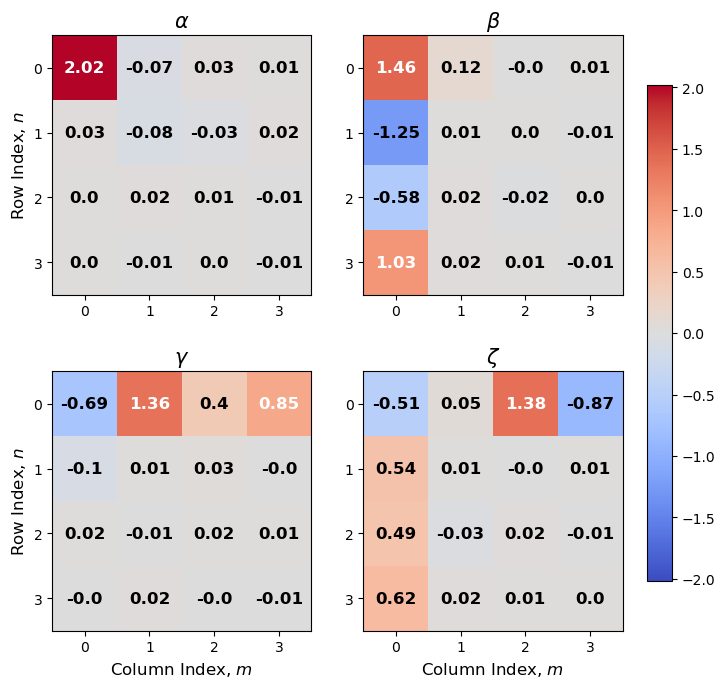

In [15]:
# Plot mean Fourier coeff values
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

titles = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\zeta$']

# find maximum absolute value for colourbar reference
maxval = np.max(Fcoeff_means) if np.max(Fcoeff_means)>abs(np.min(Fcoeff_means)) else abs(np.min(Fcoeff_means))

for idx, (ax, cm) in enumerate(zip(axes, Fcoeff_means)):
    im = ax.imshow(cm, cmap='coolwarm', vmin=-maxval, vmax=maxval)
    ax.set_title(titles[idx], fontsize=15)

    # Annotate each cell
    for i in range(params.exp_order):
        for j in range(params.exp_order):
            ax.text(j, i, f'{round(Fcoeff_means[idx][i,j],2)}',
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black',
                    fontsize=12, fontweight='bold')

    ax.set_xticks(range(params.exp_order))
    ax.set_yticks(range(params.exp_order))
    if idx in [2,3]:
        ax.set_xlabel(r'Column Index, $m$', fontsize=12)
    if idx in [0,2]:
        ax.set_ylabel(r'Row Index, $n$', fontsize=12)

# Add a shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.04, pad=0.04)
#cbar.set_label('Mean Fourier Coefficient Value', fontsize=13)

#plt.tight_layout(pad=2)
plt.savefig(f'./{save_dir}/Fcoeff.pdf')
plt.show()

### Visualise membrane curvature

In [17]:
# Set plots as pop-ups
%matplotlib qt

In [16]:
myvis = visualise(membrane_lst, nframes=50, save_dir=save_dir)

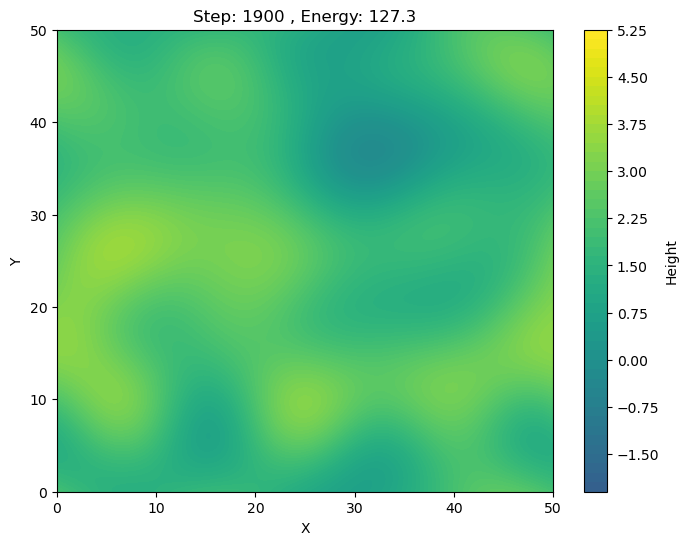

In [17]:
# Visualise membrane curvatures with contour plot movie
myvis.vis_contour()

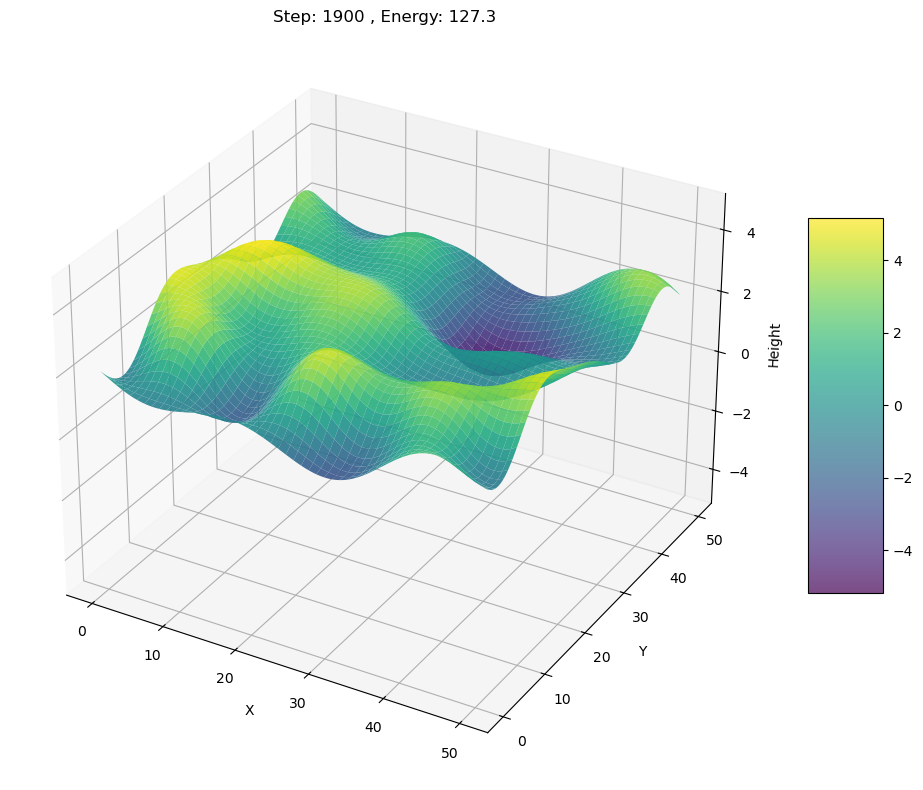

In [18]:
# Visualise membrane curvatures with 3D surface plot movie
myvis.vis_3d()

In [19]:
# Set plots to in line
%matplotlib inline

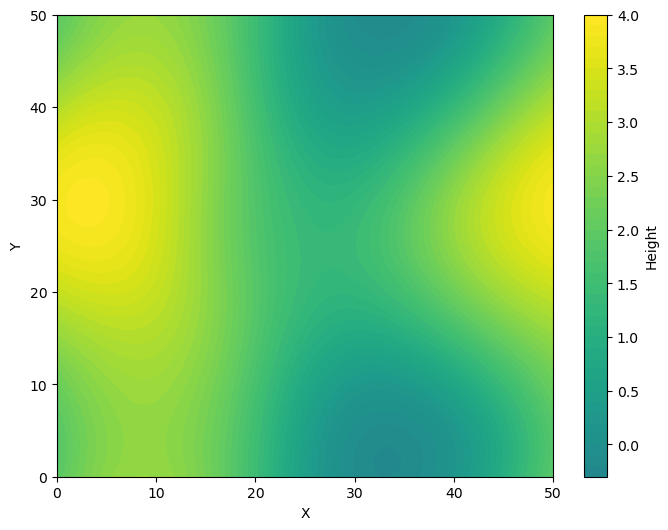

In [20]:
# Visualise 'mean surface'
mean_membrane = {
    'alpha' : alpha_mean,
    'beta'  : beta_mean,
    'gamma' : gamma_mean,
    'zeta'  : zeta_mean} 

contour_surface_plot(mean_membrane, filename=f'./{save_dir}/mean_surface')

### Save logging info

In [ ]:
log_str = f'''
# # # Parameters # # #

Box parameters:
l_x       = {params.l_x}    # Box size, x-direction
l_y       = {params.l_y}    # Box size, y-direction
exp_order = {params.exp_order}     # Order of 2D Fourier expansion
npts      = {params.npts}    # Number of points in each unit l_x, l_y for grid calculations

Bending energies:
H_0     = {params.H_0}     # Optimum mean curvature
kappa_H = {params.kappa_H}     # Bending modulus of mean curvature (kbT units)
kappa_K = {params.kappa_K}     # Bending modulus of Gaussian curvature (kbT units)

Size of Monte Carlo moves:
delta = {params.delta}     # Standard deviation of perturbation applied to Fourier coefficients

Maximum change in projected area
Original excess area = {params.original_excess_area}      39.0959290
dA_threshold         = {params.dA_threshold}  # Fraction change allowed from starting membrane

Number of steps:
nsteps = {nsteps}


# # # Results # # #

Acceptance ratio   = {naccepts/nsteps}

Curvature:
Bending energy     = {np.mean(energy_lst[int(nskip/nframes):])}
Mean curvature     = {np.mean(H_lst[int(nskip/nframes):])}
Guassian curvature = {np.mean(K_lst[int(nskip/nframes):])}

Note: averages after {nskip} steps
'''

filename = f"./{save_dir}/log.txt"

# Write the string to the file
with open(filename, "w") as file:
    file.write(log_str)

print(f'Log file saved as {filename}')